In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CellSAM segmentation model

In [2]:
# have to run the below command for every new colab session
!pip install git+https://github.com/vanvalenlab/cellSAM.git

  Cloning https://github.com/vanvalenlab/cellSAM.git to /tmp/pip-req-build-xxubwtx5
  Running command git clone --filter=blob:none --quiet https://github.com/vanvalenlab/cellSAM.git /tmp/pip-req-build-xxubwtx5
  Resolved https://github.com/vanvalenlab/cellSAM.git to commit a392cdd199eebd11646cf6dd115a992af33f6365
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-install-lltaa9qj/segment-anything_50011c503a6943d79ef7d49600623c89
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-install-lltaa9qj/segment-anything_50011c503a6943d79ef7d49600623c89
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 5

In [50]:
import numpy as np
import cv2
import torch
from cellSAM import segment_cellular_image, get_model
from skimage import measure, morphology, io
from scipy.ndimage import find_objects
from pathlib import Path
from tqdm import tqdm
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [4]:
dirpath = "/content/drive/MyDrive/LennonLab"
imgname = "20240917_delta6_100x_2.tif"
imgpath = os.path.join(dirpath, imgname)


In [5]:
projfiles = "/content/drive/MyDrive/LennonLab/cell_tracker"
projpath = os.path.join(dirpath, projfiles)
sys.path.append(os.path.abspath(projpath))


In [6]:
DEFAULT_CONFIG = {
    'preprocessing': {
        'inpaint': True,
        'gaussian_blur_enabled': False,
        'gaussian_blur_sigma': 1.0
    },
    'segmentation': {
        'bbox_threshold': 0.4
    },
    'postprocessing': {
        'min_object_size': 200,
        'merge_overlap_threshold': 0.5
    }
}

In [7]:
class ImageLoader:
    """Handles image loading and validation operations."""

    @staticmethod
    def load_image(image_path):
        """Load an image from the specified path."""
        path = Path(image_path)
        if not path.exists():
            raise FileNotFoundError(f"Image not found: {image_path}")

        try:
            img = io.imread(str(path))
            print(f"Successfully loaded image: {path.name}")
            return img
        except Exception as e:
            print(f"Error loading image: {e}")
            raise

Successfully loaded image: 20240917_delta6_100x_2.tif


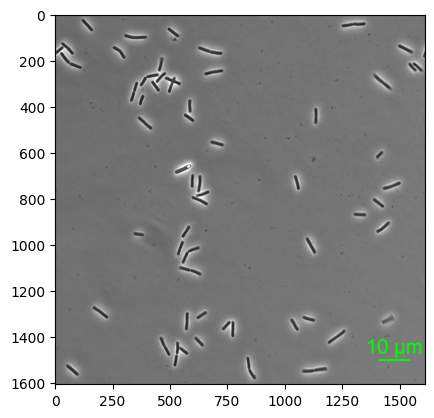

In [8]:
il = ImageLoader()
img = il.load_image(imgpath)
plt.imshow(img)

In [9]:
class Preprocessor:
    """Handles image preprocessing operations."""

    def __init__(self, *,
                 inpaint=True,
                 gaussian_blur_enabled=False,
                 gaussian_blur_sigma=1.0
                 ):
        """Initialize preprocessor with direct parameters."""
        self.inpaint = inpaint
        self.gaussian_blur_enabled = gaussian_blur_enabled
        self.gaussian_blur_sigma = gaussian_blur_sigma


    def process(self, img):
        """Apply all preprocessing steps to the image."""
        if self.inpaint:
            img = self.inpaint_image(img)

        if self.gaussian_blur_enabled:
            img = cv2.GaussianBlur(img, (0, 0), self.gaussian_blur_sigma)

        return img

    def inpaint_image(self, img, inpaint_radius=5):
        """Remove artifacts using inpainting."""
        mask = (img[:, :, 0] != img[:, :, 1]) | (img[:, :, 0] != img[:, :, 2])
        mask = mask.astype(np.uint8) * 255
        return cv2.inpaint(img, mask, inpaintRadius=inpaint_radius, flags=cv2.INPAINT_TELEA)


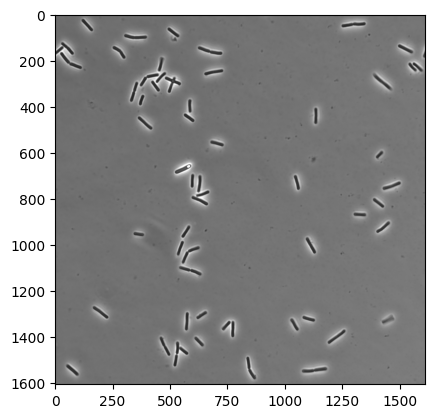

In [10]:
prep = Preprocessor(**DEFAULT_CONFIG['preprocessing'])
img1 = prep.process(img)
plt.imshow(img1)

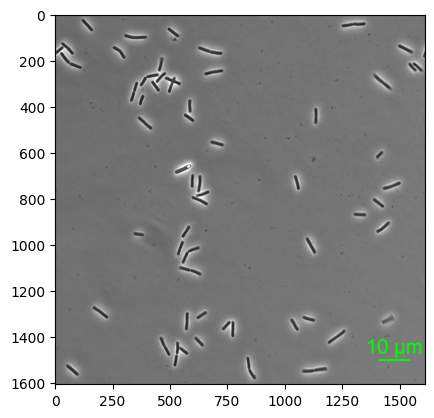

In [11]:
# to change a DEFAULT_CONFIG value
DEFAULT_CONFIG['preprocessing']['inpaint'] = False

prep = Preprocessor(**DEFAULT_CONFIG['preprocessing'])
test_image = prep.process(img)
plt.imshow(test_image)

In [41]:
class Segmenter:
    """Handles single-image segmentation using cellSAM."""

    def __init__(self, *, bbox_threshold=0.14):
        """
        Initialize segmenter for full images.

        Args:
            bbox_threshold (float): Confidence threshold for bounding boxes
        """
        self.bbox_threshold = bbox_threshold
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        # self.bounding_boxes = None

    def load_model(self):
        """ Load the cellSAM model if not already loaded.'
            TODO:
              add functionality to get model directly from saved .pt instead of downloading everytime
        """
        if self.model is None:
            self.model = get_model()
        return self.model

    def segment(self, img):
        """
        Segment a single image using cellSAM.

        Args:
            img (np.ndarray): Input image

        Returns:
            tuple: (mask, bbox) segmentation mask and bounding boxes
        """
        self.load_model()
        mask, _, bbox = segment_cellular_image(
            img,
            device=str(self.device),
            model = self.model,
            normalize = True,
            fast = True,
            bbox_threshold=self.bbox_threshold
            # ,bounding_boxes=self.bounding_boxes
        )
        boxes = bbox[0].cpu().numpy()
        return mask, boxes

    def get_cell_properties(self, mask):
      """
      Extract cell centers and tight bounding boxes from a labeled mask.

      Args:
          mask (np.ndarray): Labeled mask where each cell has a unique integer value

      Returns:
          tuple: (centers, bboxes) where:
              - centers is a list of (y, x) coordinates for each cell center
              - bboxes is a list of [min_y, min_x, max_y, max_x] for each cell
      """
      # Get properties of each labeled region
      props = measure.regionprops(mask)

      # Extract centers and bounding boxes
      centers = [prop.centroid for prop in props]  # (y, x) coordinates
      bboxes = [prop.bbox for prop in props]  # (min_y, min_x, max_y, max_x)
      # Convert the bboxes to the required format as a list of floats
      boxes = [[float(min_x), float(min_y), float(max_x), float(max_y)] for (min_y, min_x, max_y, max_x) in bboxes]

      # self.bounding_boxes = boxes
      # using the boxes as inputs to the model results in a bad segmentation.
      ## it looks like the area of the input boxes get's compressed for some reason so the model doesn't
      ## seem to run on the whole image (only when bounding boxes are input)
      return centers, boxes


    def visualize(self, img, mask, boxes):
        """
        Visualize segmentation results.

        Args:
            img (np.ndarray): Original image
            mask (np.ndarray): Segmentation mask
            boxes (np.ndarray): Bounding boxes (already in numpy format)
        """
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        ax1.imshow(img)
        ax1.set_title("Original Image")
        ax1.axis('off')

        # Mask overlay
        ax2.imshow(img)
        colored_mask = np.ma.masked_where(mask == 0, mask)
        ax2.imshow(colored_mask, cmap='hsv', alpha=0.5)
        ax2.set_title("Segmentation Mask")
        ax2.axis('off')

        # Bounding boxes
        ax3.imshow(img)
        for box in boxes:  # No need for cpu().numpy() conversion
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=1, edgecolor='r', facecolor='none'
            )
            ax3.add_patch(rect)
        ax3.set_title("Bounding Boxes")
        ax3.axis('off')

        plt.tight_layout()
        plt.show()

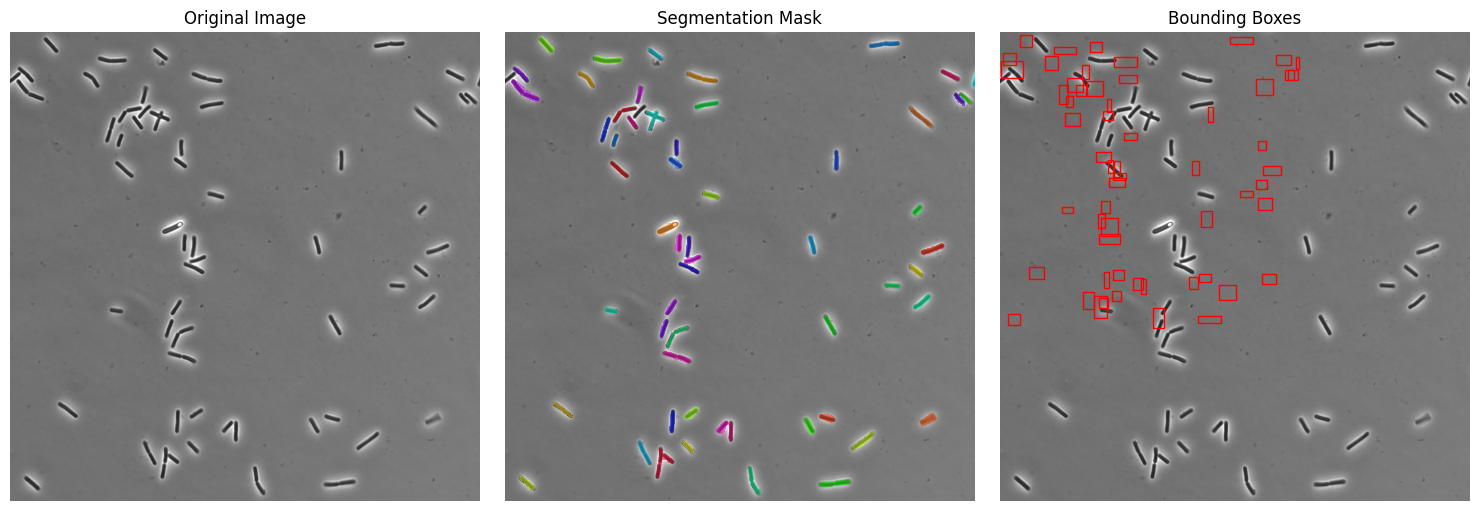

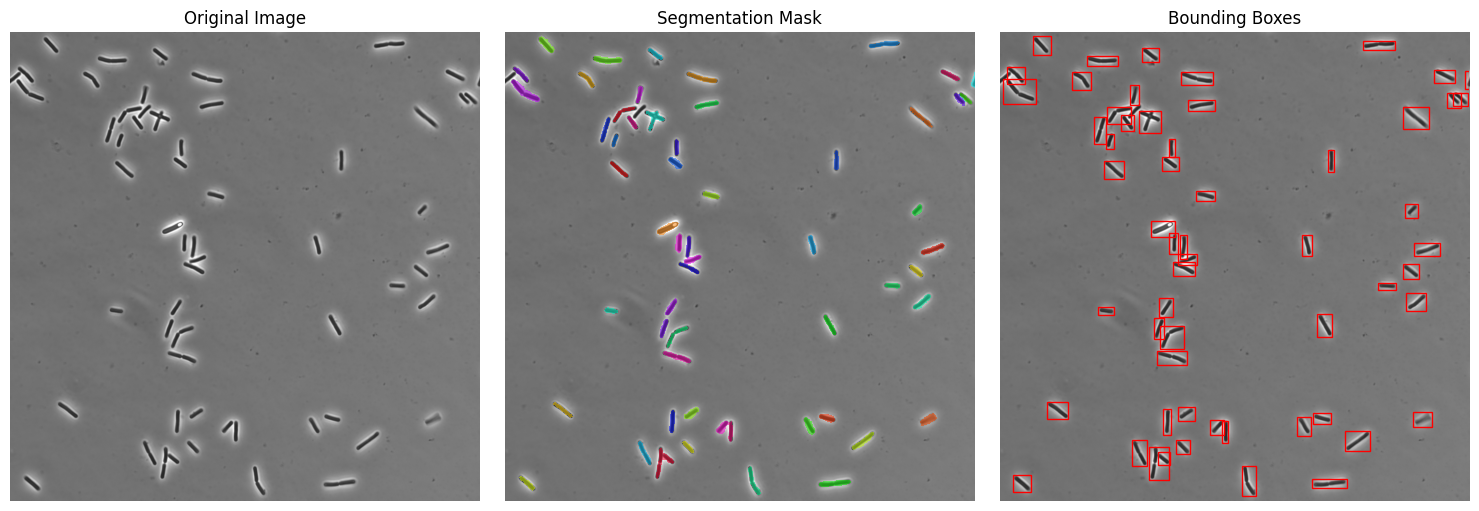

In [42]:
seg = Segmenter(**DEFAULT_CONFIG['segmentation'])
mask,bbox = seg.segment(img1)
seg.visualize(img1, mask, bbox)
centers, boxes = seg.get_cell_properties(mask)
seg.visualize(img1, mask, boxes)


In [43]:
len(boxes)

58

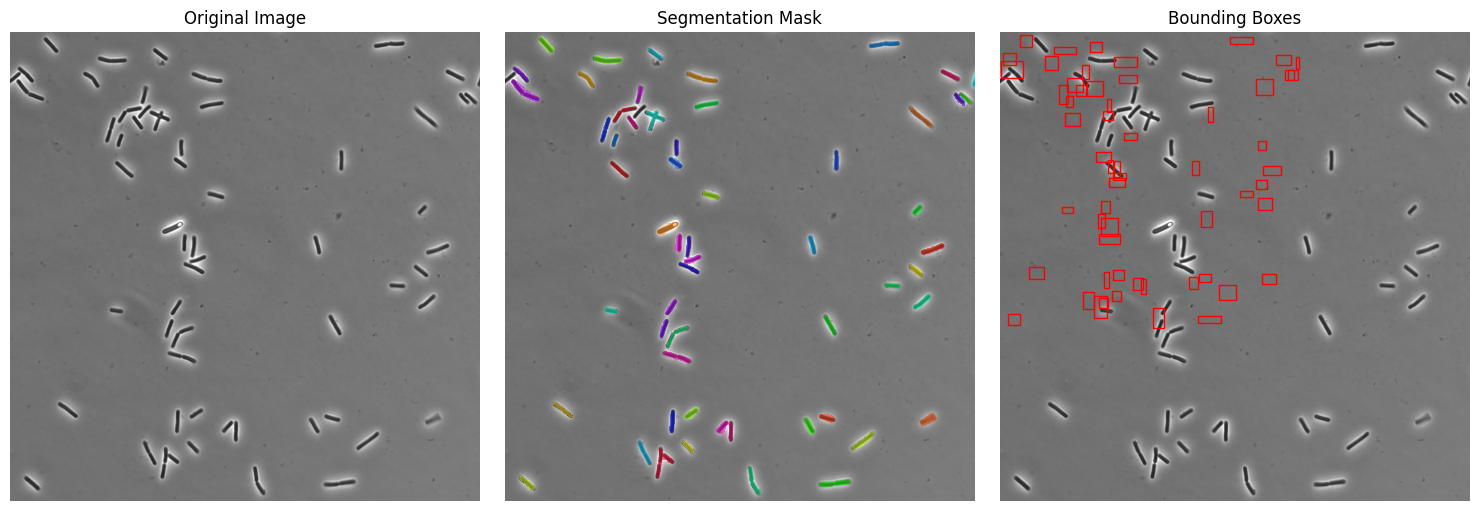

In [44]:
mask2, bbox2 = seg.segment(img1)
seg.visualize(img1, mask2, bbox2)

TODO:

- Figure out how to use bounding boxes found in get_cell_properties can be used as input to the segmentation
  - currently it looks like the area of the bounding boxes get's shrunk for some reason when the model is run and the resulting cell detections are likewise compressed to a smaller area (see images directly above)
  - I think you would have to look into the sam_inference.py file to see where this is going wrong
  - REMOVED setting bounding_boxes with the boxes found so the model doesn't take those as input.
    - to test this, uncomment out every line with bounding_boxes in it. set bounding_boxes as a parameter, add it to segment_cellular_image functionality, and set the class parameter in the get_cell_properties method.


- using cellSAMs segment_cellular_image with the postprocess argument set to True results in a really long wait time for segmentation and then only returns a single cell that has been detected.
  - the cellSAM .utils file has functionality for postprocessing that I didn't implement but it is something to look into to see if it could improve the results.
  - https://github.com/vanvalenlab/cellSAM/blob/master/cellSAM/utils.py



# Segmentation by Quadrants

In [55]:


class QuadrantSegmenter:
    """
    Processes images by splitting them into quadrants, running the segmentation model
    on each quadrant, then recombining the masks. If any objects span multiple quadrants,
    they will be merged into a single connected object in the final mask.
    """

    def __init__(self, base_segmenter):
        """
        Initialize the QuadrantSegmenter with an existing Segmenter instance.

        Args:
            base_segmenter (Segmenter): An instance of the Segmenter class with a loaded model.
        """
        self.base_segmenter = base_segmenter
        self.model = self.base_segmenter.load_model()  # Ensure model is loaded
        self.bounding_boxes = None
        self.quadrant_results = {}  # Will store quadrant masks and boxes for visualization if needed

    def segment_by_quadrants(self, img, visualize_quadrants=False, remove_small_obj=False, min_size=20):
        """
        Segment the image by dividing it into quadrants, segmenting each separately, and then merging.

        Args:
            img (np.ndarray): Input image to be segmented.
            visualize_quadrants (bool): If True, stores quadrant results so that they can be visualized later.
            remove_small_obj (bool): If True, removes small objects after merging quadrants.
            min_size (int): Minimum size (in pixels) of objects to keep.

        Returns:
            tuple: (final_mask, final_boxes)
                - final_mask (np.ndarray): A labeled mask of the full image.
                - final_boxes (list): Bounding boxes of the detected objects after merging.
        """
        H, W = img.shape[:2]
        mid_h = H // 2
        mid_w = W // 2

        # Extract quadrants
        img_tl = img[0:mid_h, 0:mid_w]
        img_tr = img[0:mid_h, mid_w:W]
        img_bl = img[mid_h:H, 0:mid_w]
        img_br = img[mid_h:H, mid_w:W]

        # Segment each quadrant
        mask_tl, boxes_tl = self.base_segmenter.segment(img_tl)
        mask_tr, boxes_tr = self.base_segmenter.segment(img_tr)
        mask_bl, boxes_bl = self.base_segmenter.segment(img_bl)
        mask_br, boxes_br = self.base_segmenter.segment(img_br)

        # Store the quadrant results for visualization
        self.quadrant_results = {
            'top_left': (img_tl, mask_tl, boxes_tl),
            'top_right': (img_tr, mask_tr, boxes_tr),
            'bottom_left': (img_bl, mask_bl, boxes_bl),
            'bottom_right': (img_br, mask_br, boxes_br)
        }

        # Convert masks to integer type
        mask_tl = mask_tl.astype(np.int32)
        mask_tr = mask_tr.astype(np.int32)
        mask_bl = mask_bl.astype(np.int32)
        mask_br = mask_br.astype(np.int32)

        # Compute label offsets to ensure uniqueness across quadrants
        max_label_tl = mask_tl.max()
        mask_tr[mask_tr > 0] += max_label_tl
        max_label_tr = mask_tr.max() if mask_tr.max() > 0 else max_label_tl
        mask_bl[mask_bl > 0] += max_label_tr
        max_label_bl = mask_bl.max() if mask_bl.max() > 0 else max_label_tr
        mask_br[mask_br > 0] += max_label_bl

        # Recombine masks into one big mask
        final_mask = np.zeros((H, W), dtype=np.int32)
        final_mask[0:mid_h, 0:mid_w] = mask_tl
        final_mask[0:mid_h, mid_w:W] = mask_tr
        final_mask[mid_h:H, 0:mid_w] = mask_bl
        final_mask[mid_h:H, mid_w:W] = mask_br

        # Handle objects that cross quadrant boundaries
        final_mask, _ = measure.label(final_mask, background=0, return_num=True)

        # remove small objects if remove_small_obj is set
        if remove_small_obj:
            final_mask = self.remove_small_objects(final_mask, min_size=min_size)

        # Get final properties (centers and boxes)
        centers, final_boxes = self.get_cell_properties(final_mask)

        # visualize each quadrant separately if visualize_quadrants is set
        if visualize_quadrants:
            self.visualize_quadrants()

        return final_mask, final_boxes

    def remove_small_objects(self, mask, min_size=20):
        """
        Remove small objects from the mask by area.

        Args:
            mask (np.ndarray): The labeled mask image.
            min_size (int): Minimum size (in pixels) of objects to keep.

        Returns:
            mask (np.ndarray): The mask after small objects have been removed.
        """
        props = measure.regionprops(mask)
        for prop in props:
            if prop.area < min_size:
                # Set the object's pixels to 0 to remove it
                mask[mask == prop.label] = 0

        # Re-label after removal
        mask, _ = measure.label(mask, background=0, return_num=True)
        return mask

    def visualize_quadrants(self):
        """
        Visualize the segmentation results for each quadrant if stored.
        """
        # self.quadrant_results stores tuples of (img, mask, boxes) for each quadrant
        for quadrant_name, (q_img, q_mask, q_boxes) in self.quadrant_results.items():
            print(f"Visualizing {quadrant_name} quadrant:")
            self.visualize(q_img, q_mask, q_boxes)

    def get_cell_properties(self, mask):
        """
        Extract cell centers and tight bounding boxes from a labeled mask.

        Args:
            mask (np.ndarray): Labeled mask where each cell has a unique integer value.

        Returns:
            tuple: (centers, boxes) where:
                - centers is a list of (y, x) coordinates for each cell center
                - boxes is a list of [min_x, min_y, max_x, max_y] for each cell
        """
        props = measure.regionprops(mask)

        # Extract centers and bounding boxes
        centers = [prop.centroid for prop in props]  # (y, x) coordinates
        bboxes = [prop.bbox for prop in props]  # (min_y, min_x, max_y, max_x)

        # Convert the bboxes to the format [min_x, min_y, max_x, max_y]
        boxes = [[float(min_x), float(min_y), float(max_x), float(max_y)] for (min_y, min_x, max_y, max_x) in bboxes]

        self.bounding_boxes = boxes
        return centers, boxes

    def visualize(self, img, mask, boxes):
        """
        Visualize the segmentation results.

        Args:
            img (np.ndarray): Original image
            mask (np.ndarray): Final segmentation mask
            boxes (list): Bounding boxes of the objects
        """
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        ax1.imshow(img)
        ax1.set_title("Original Image")
        ax1.axis('off')

        # Mask overlay
        ax2.imshow(img)
        colored_mask = np.ma.masked_where(mask == 0, mask)
        ax2.imshow(colored_mask, cmap='hsv', alpha=0.5)
        ax2.set_title("Segmentation Mask")
        ax2.axis('off')

        # Bounding boxes
        ax3.imshow(img)
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=1, edgecolor='r', facecolor='none'
            )
            ax3.add_patch(rect)
        ax3.set_title("Bounding Boxes")
        ax3.axis('off')

        plt.tight_layout()
        plt.show()


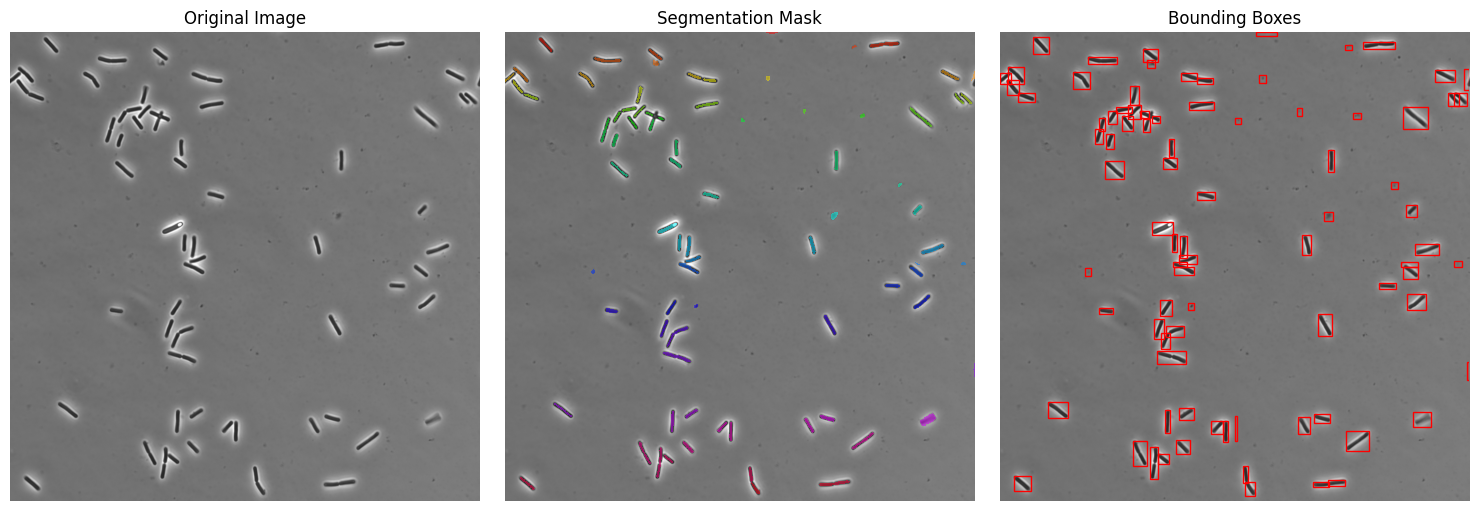

In [64]:
base_segmenter = Segmenter(bbox_threshold=0.14)
quad_segmenter = QuadrantSegmenter(base_segmenter)
quad_mask, quad_boxes = quad_segmenter.segment_by_quadrants(img1, remove_small_obj=True, min_size=350)
quad_segmenter.visualize(img1, quad_mask, quad_boxes)